
## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pycountry_convert as pc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.preprocessing import Normalizer
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


## Exploratory Data Analysis

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [3]:
df.info

<bound method DataFrame.info of        num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0                   2      Internet  RoundTrip            262              19   
1                   1      Internet  RoundTrip            112              20   
2                   2      Internet  RoundTrip            243              22   
3                   1      Internet  RoundTrip             96              31   
4                   2      Internet  RoundTrip             68              22   
...               ...           ...        ...            ...             ...   
49995               2      Internet  RoundTrip             27               6   
49996               1      Internet  RoundTrip            111               6   
49997               1      Internet  RoundTrip             24               6   
49998               1      Internet  RoundTrip             15               6   
49999               1      Internet  RoundTrip             19               6

In [4]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

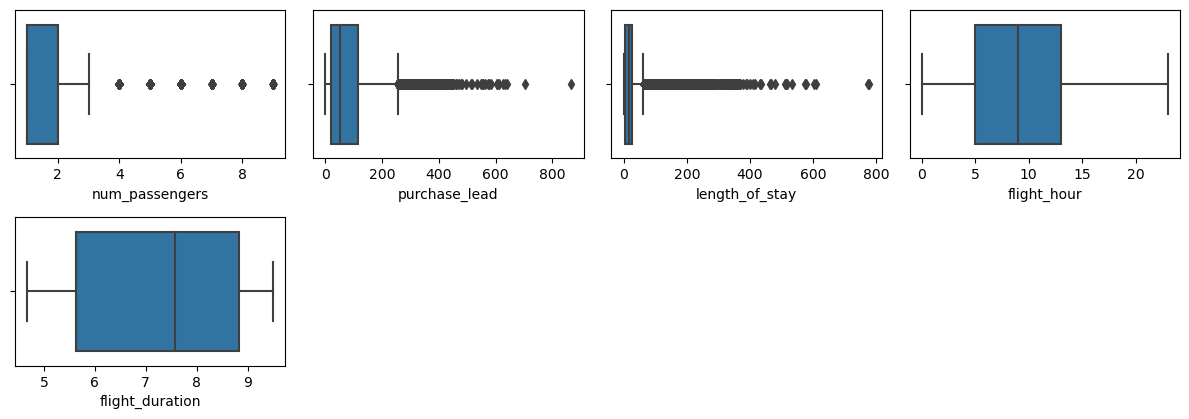

In [5]:
num = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
plt.figure(figsize=(12,8))

for i, column in enumerate (df[num].columns, 1):
    plt.subplot(4,4,i)
    sns.boxplot(data=df[num], x=df[column])
    plt.tight_layout()

## Important Features

In [6]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete         

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [7]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [8]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

route                    0.051237
booking_origin           0.047794
flight_duration          0.018538
wants_extra_baggage      0.010624
length_of_stay           0.009386
purchase_lead            0.003573
wants_preferred_seat     0.003348
wants_in_flight_meals    0.002963
num_passengers           0.002712
flight_hour              0.001754
trip_type                0.000951
sales_channel            0.000689
flight_day               0.000000
Name: MI Scores, dtype: float64

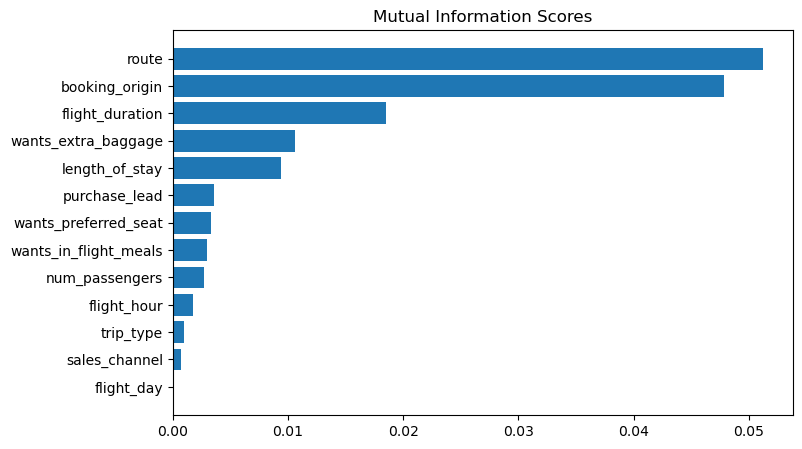

In [9]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

We can see

1.   route 
2.   booking_origin
3.   flight_duration          
4.   wants_extra_baggage      
5.   length_of_stay          

 are the top 5 features which are dependant with booking_complete feature

In [10]:
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.2,random_state = 0)

# Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25,random_state = 0)
    return (train_X, val_X, train_y, val_y)

In [11]:
def scale(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return X

## Ml MODELS

### Random forest classifier with top 6 features

In [12]:
features=['route','booking_origin','flight_duration','wants_extra_baggage', 'length_of_stay','num_passengers']
X= df[features]
#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  83.37
AUC score:  0.5658407543873134


### Random forest classifier with all features

In [13]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete       

X_train,X_val,y_train,y_val= dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
preds= forest_model.predict(X_val)

print('ACCURACY: ',accuracy_score(y_val,preds)*100)
print('AUC score: ',roc_auc_score(y_val,preds))

ACCURACY:  84.78
AUC score:  0.547806680112837


### XGB classifier with top 6 features

In [14]:
X= df[features]

#one hot encoding
X = pd.get_dummies(X, columns=features)
X= scale(X)

y= df.booking_complete    

X_train,X_val,y_train,y_val= dataset(X,y)
xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  84.72
AUC score:  0.5189398567740671


### XGB classifier with all features

In [15]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete 

X_train,X_val,y_train,y_val= dataset(X,y)


xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
prediction_xgb = xgb_model.predict(X_val)
print('ACCURACY: ',accuracy_score(y_val, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_val,prediction_xgb))

ACCURACY:  84.98
AUC score:  0.5424676175552812


Finalizing random forest model with all features as final model, as it has goos accuracy and higher auc score compared to other models

Validating with test data set

In [16]:
X= df.drop('booking_complete',axis=1)
#one hot encoding
X = pd.get_dummies(X)
X= scale(X)
y= df.booking_complete       

train_full_X,test_X, train_full_y, test_y = train_test_split(X, y,test_size=0.2,random_state = 0)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(train_full_X, train_full_y)
preds= forest_model.predict(test_X)

print('ACCURACY: ',accuracy_score(test_y,preds)*100)
print('AUC score: ',roc_auc_score(test_y,preds))

ACCURACY:  85.13
AUC score:  0.5591015488016313


### Making new feature

In [17]:
is_weekend = []

for i in range(len(df)):
    if df['flight_day'][i] == 6 or df['flight_day'][i] == 7:
        is_weekend.append(1)
    else:
        is_weekend.append(0)

df['is_weekend'] = is_weekend
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,is_weekend
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0,0


In [18]:
continent = []
index = []

df['booking_origin'] =  df['booking_origin'].replace('Myanmar (Burma)', 'Myanmar')

for i in range(len(df)):
    country = df['booking_origin'][i]
    #print(country)
    try :
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_name = pc.country_alpha2_to_continent_code(country_code)
        continent.append(continent_name)
    except:
        continent.append('Others')

df['booking_continent'] = continent

In [19]:
df['booking_continent'].value_counts()

AS        29740
OC        18960
EU          578
NA          525
Others       87
AF           69
SA           41
Name: booking_continent, dtype: int64

In [20]:
df.drop('booking_origin',axis=1, inplace=True)

In [21]:
print(f'Total rows before delete outlier : {len(df)}')

filtered_entries = np.array([True] * len(df))

for col in num:
    zscore = abs(stats.zscore(df[col]))
    filtered_entries = (zscore < 3) & filtered_entries
    df = df[filtered_entries]
    
print(f'Total rows after delete outlier : {len(df)}')

Total rows before delete outlier : 50000
Total rows after delete outlier : 47115


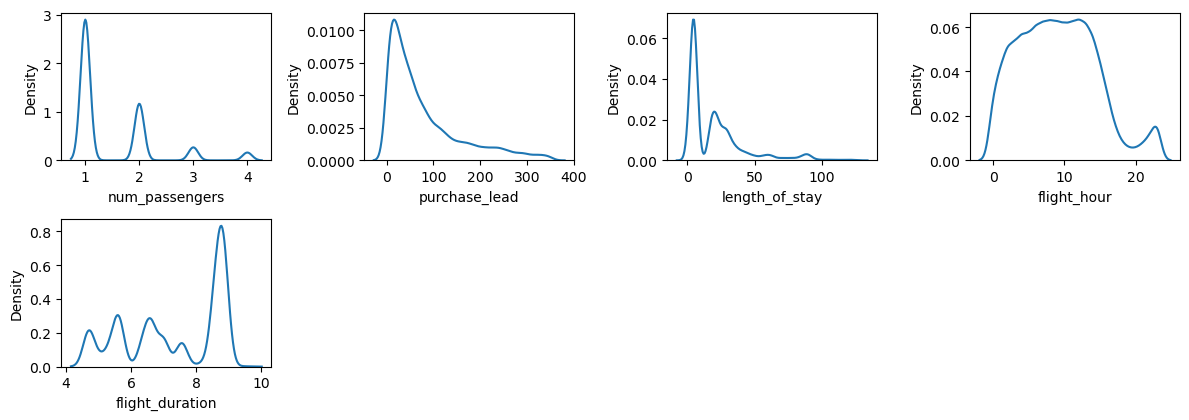

In [22]:
plt.figure(figsize=(12,8))

for i, column in enumerate (df[num].columns, 1):
    plt.subplot(4,4,i)
    sns.kdeplot(data=df[num], x=df[column])
    plt.tight_layout()

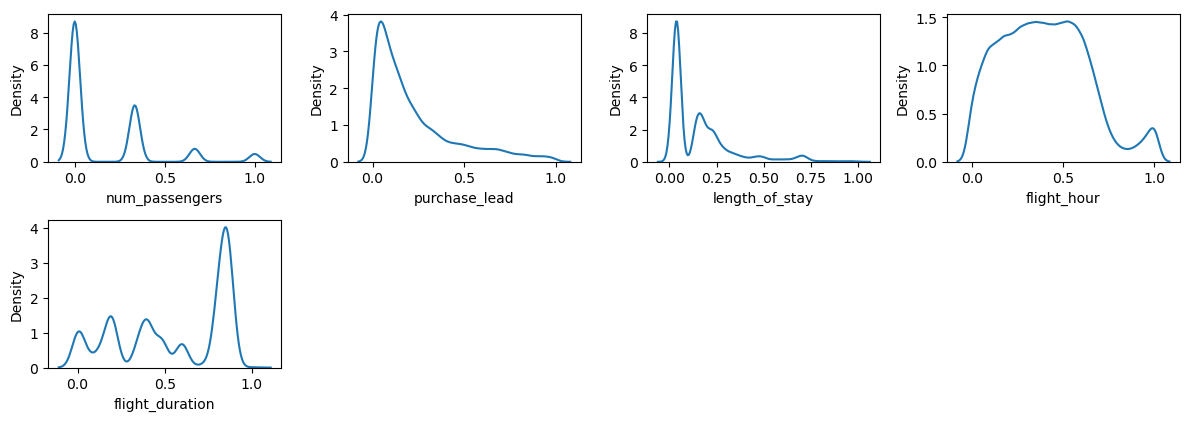

In [23]:
num_max = df[num].max()
num_min = df[num].min()

num_features = (df[num] - num_min) / (num_max - num_min)
num_features.head()

df[num] = num_features

plt.figure(figsize=(12,8))

for i, column in enumerate (df[num].columns, 1):
    plt.subplot(4,4,i)
    sns.kdeplot(data=df, x=df[column])
    plt.tight_layout()